# Generate "clean" Myeloid cell subset

In this notebook, we'll read the cleaned PBMC reference dataset, select L1 cell types, and generate subset AnnData objects for each with updated UMAP projections.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc
import scanpy.external as sce

In [2]:
def read_adata_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file)
    return adata

In [3]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [4]:
out_files = []

## Read annotated dataset

In [5]:
h5ad_uuid = '6e8972a5-9463-4230-84b4-a20de055b9c3'

In [6]:
adata = read_adata_uuid(h5ad_uuid)

In [7]:
adata.shape

(1823666, 1261)

## Generate Myeloid cell object

In [8]:
cell_class = 'myeloid-cells'
keep_labels = ['DC', 'Monocyte']

In [9]:
adata_subset = adata[adata.obs['AIFI_L1'].isin(keep_labels)]
adata_subset.shape

(351206, 1261)

In [10]:
obs = adata_subset.obs.copy()
obs['AIFI_L1'] = obs['AIFI_L1'].cat.remove_unused_categories()
obs['AIFI_L2'] = obs['AIFI_L2'].cat.remove_unused_categories()
obs['AIFI_L3'] = obs['AIFI_L3'].cat.remove_unused_categories()
adata_subset.obs = obs

### Re-project within the subset

In [11]:
adata_subset = adata_subset.raw.to_adata()

In [12]:
adata_subset.raw = adata_subset

In [13]:
sc.pp.normalize_total(adata_subset, target_sum = 1e4)

In [14]:
sc.pp.log1p(adata_subset)
sc.pp.highly_variable_genes(adata_subset)

In [15]:
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]].copy()

In [16]:
sc.pp.scale(adata_subset)

In [17]:
sc.tl.pca(adata_subset, svd_solver='arpack')

In [18]:
sce.pp.harmony_integrate(
    adata_subset, 
    'cohort.cohortGuid',
    max_iter_harmony = 30)

2024-03-09 22:09:22,065 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-09 22:15:34,087 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-09 22:15:36,927 - harmonypy - INFO - Iteration 1 of 30
2024-03-09 22:20:55,674 - harmonypy - INFO - Iteration 2 of 30
2024-03-09 22:25:44,271 - harmonypy - INFO - Converged after 2 iterations


In [19]:
sc.pp.neighbors(
    adata_subset, 
    n_neighbors = 50,
    use_rep = 'X_pca_harmony', 
    n_pcs = 30)

In [20]:
sc.tl.umap(adata_subset, min_dist = 0.05)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


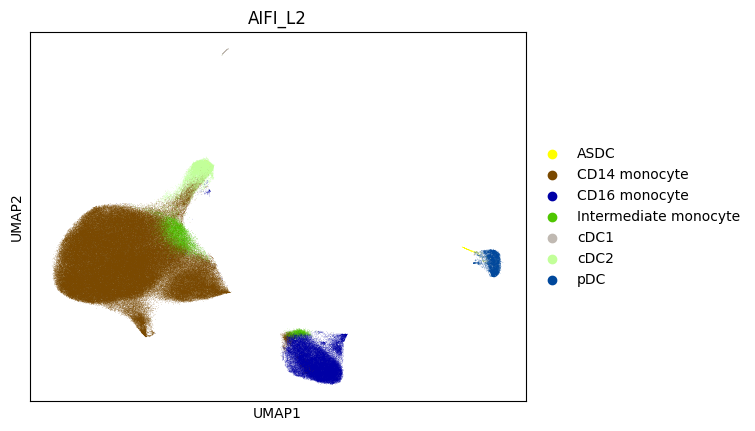

In [21]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L2'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


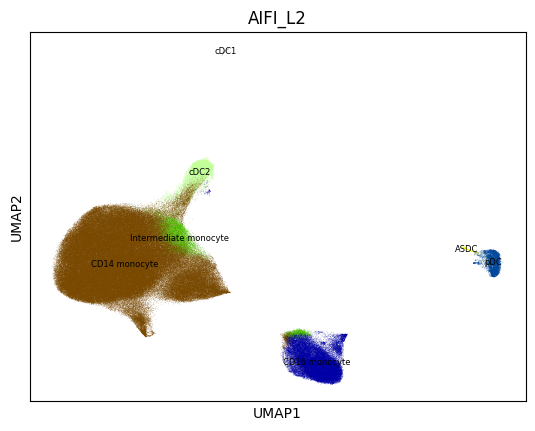

In [22]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L2',
    legend_loc = 'on data',
    legend_fontsize = 6,
    legend_fontweight = 'normal'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


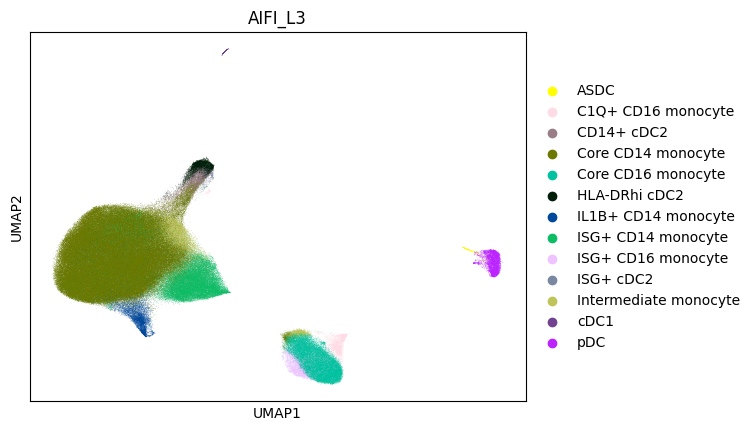

In [23]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L3'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


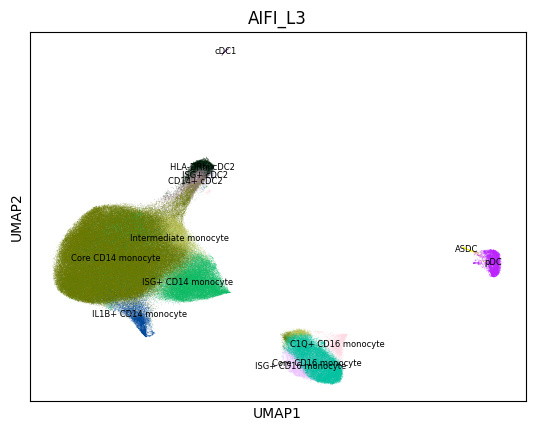

In [24]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L3',
    legend_loc = 'on data',
    legend_fontsize = 6,
    legend_fontweight = 'normal'
)

### Output subset annotations

In [25]:
obs = adata_subset.obs
obs = obs.reset_index(drop = True)

In [26]:
umap_mat = adata_subset.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [27]:
obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,leiden,AIFI_L1,AIFI_L2,AIFI_L3,keep,umap_1,umap_2
0,cf71fa1048b611ea8957bafe6d70929e,B001,impatient_familial_cuckoo,cf71fa1048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1246,204,11107,...,204,5.323010,5.935409,3,Monocyte,CD14 monocyte,Core CD14 monocyte,True,-1.682847,3.745049
1,cf71ffba48b611ea8957bafe6d70929e,B001,dastardly_wintery_airedale,cf71ffba48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1965,363,15979,...,363,5.897154,6.871096,9,Monocyte,CD14 monocyte,Core CD14 monocyte,True,-2.175015,-1.567871
2,cf72153648b611ea8957bafe6d70929e,B001,svelte_frenzied_kusimanse,cf72153648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1246,69,9481,...,69,4.248495,2.474005,24,DC,pDC,pDC,True,13.424586,1.351796
3,cf721da648b611ea8957bafe6d70929e,B001,silvery_uncouth_sturgeon,cf721da648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1322,93,9883,...,93,4.543295,2.932829,3,Monocyte,CD14 monocyte,Core CD14 monocyte,True,-3.663888,2.572800
4,cf7221e848b611ea8957bafe6d70929e,B001,obtuse_visible_icefish,cf7221e848b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1626,280,15824,...,280,5.638355,5.764875,3,Monocyte,CD14 monocyte,Core CD14 monocyte,True,-2.111854,3.674115


In [28]:
obs_out_csv = '{p}/ref_clean_pbmc_{c}_labeled_meta_umap_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_csv(obs_out_csv, index = False)
out_files.append(obs_out_csv)

In [29]:
obs_out_parquet = '{p}/ref_clean_pbmc_{c}_labeled_meta_umap_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_parquet(obs_out_parquet, index = False)
out_files.append(obs_out_parquet)

### Output subset AnnData

In [30]:
out_h5ad = '{p}/ref_clean_pbmc_{c}_labeled_{d}.h5ad'.format(p = out_dir, c = cell_class, d = date.today())
adata_subset.write_h5ad(out_h5ad)
out_files.append(out_h5ad)

## Upload results to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [31]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'PBMC Clean Reference Myeloid cells {d}'.format(d = date.today())

In [32]:
in_files = [h5ad_uuid]

In [33]:
in_files

['6e8972a5-9463-4230-84b4-a20de055b9c3']

In [34]:
out_files

['output/ref_clean_pbmc_myeloid-cells_labeled_meta_umap_2024-03-09.csv',
 'output/ref_clean_pbmc_myeloid-cells_labeled_meta_umap_2024-03-09.parquet',
 'output/ref_clean_pbmc_myeloid-cells_labeled_2024-03-09.h5ad']

In [35]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

output/ref_clean_pbmc_myeloid-cells_labeled_meta_umap_2024-03-09.csv
output/ref_clean_pbmc_myeloid-cells_labeled_meta_umap_2024-03-09.parquet
output/ref_clean_pbmc_myeloid-cells_labeled_2024-03-09.h5ad
Cannot determine the current notebook.
1) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/26-Python_clean_NK_cell_projections.ipynb
2) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/25-Python_clean_Myeloid_cell_projections.ipynb
3) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/24-Python_clean_B_cell_projections.ipynb
Please select (1-3) 


 2


you are trying to upload file_ids... ['output/ref_clean_pbmc_myeloid-cells_labeled_meta_umap_2024-03-09.csv', 'output/ref_clean_pbmc_myeloid-cells_labeled_meta_umap_2024-03-09.parquet', 'output/ref_clean_pbmc_myeloid-cells_labeled_2024-03-09.h5ad']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'c8e2890f-c88b-46ef-ad58-2b454707cae5',
 'files': ['output/ref_clean_pbmc_myeloid-cells_labeled_meta_umap_2024-03-09.csv',
  'output/ref_clean_pbmc_myeloid-cells_labeled_meta_umap_2024-03-09.parquet',
  'output/ref_clean_pbmc_myeloid-cells_labeled_2024-03-09.h5ad']}

In [36]:
import session_info
session_info.show()